In [1]:
# 0. Settings
!pip install laion-clap
!pip install torch
!pip install torchvision
!pip install torchaudio
import laion_clap
import glob
import json
import torch
import numpy as np
import torchaudio
import tarfile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob


# Instrument Classification

In [2]:
# 1. labels/audio/text files path  

# files
class_index_dict_path = 'labels/sc.json'
zip_files_path = 'data/S300.zip'
unzip_files_folder_path = 'data/S300/'
upzip_audio_files_path = 'data/S300/**/*.wav'
upzip_text_files_path = 'data/S300/**/*.json'
column_name = 'sc' # 'genre', 'artist'


In [3]:
# 2. Pretrained Model calling
model = laion_clap.CLAP_Module(enable_fusion=True)
model.load_ckpt()

with zipfile.ZipFile(zip_files_path) as zip:
    zip.extractall(unzip_files_folder_path)
class_index_dict = {k:v for k, v in json.load(open(class_index_dict_path)).items()}
audio_files = sorted(glob.glob(upzip_audio_files_path, recursive=True))
json_files = sorted(glob.glob(upzip_text_files_path, recursive=True)) 
ground_truth_idx = [class_index_dict[json.load(open(jf))[column_name][0]] for jf in json_files]

/home/jeong_soonju/default/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

In [4]:
print('='*50)
print(class_index_dict)
print('audio files 갯수:',len(audio_files))
print('json_files 갯수:',len(json_files))
print('ground_truth_idx 갯수:',len(ground_truth_idx))
print('ground_truth_idx :' ,ground_truth_idx)

{'lead': 0, 'bass': 1, 'pluck': 2, 'hihat': 3, 'snare': 4, 'kick': 5, 'tom': 6, 'cymbals': 7}
audio files 갯수: 232
json_files 갯수: 232
ground_truth_idx 갯수: 232
ground_truth_idx : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 1, 4, 4, 4, 5, 5, 4, 4, 4, 4, 6, 6, 1, 1, 1, 3, 5, 1, 7, 7, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 3, 3, 5, 5, 5, 4, 4, 1, 4, 5, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 3, 3, 3, 3, 3, 5, 5, 5, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 5, 7, 3, 3, 3, 4, 4, 7, 7, 7, 7, 7, 3, 3, 5, 2, 2, 2, 2, 7, 7, 7, 5, 1, 1, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 7, 3, 4, 5, 5, 4, 4]


In [5]:
# 3. Zero-shot processing
with torch.no_grad():
    ground_truth = torch.tensor(ground_truth_idx).view(-1, 1)
    # Get text features
    all_texts = ["This song is " + t for t in class_index_dict.keys()]
    text_embed = model.get_text_embedding(all_texts)
    audio_embed = model.get_audio_embedding_from_filelist(x=audio_files[:300]) 
    print('text_embed shape :',text_embed.shape)
    print('audio_embed shape :',audio_embed.shape)

/home/jeong_soonju/default/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
/home/jeong_soonju/default/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


text_embed shape : (8, 512)
audio_embed shape : (232, 512)


In [6]:
    ranking = torch.argsort(torch.tensor(audio_embed) 
                            @ torch.tensor(text_embed).t(), 
                            descending=True)
    preds = torch.where(ranking == ground_truth)[1]
    preds_text=preds
    preds = preds.cpu().numpy()
    metrics = {}
    metrics[f"mean_rank"] = preds.mean() + 1
    metrics[f"median_rank"] = np.floor(np.median(preds)) + 1
    for k in [1, 2, 3, 5]:
        metrics[f"R@{k}"] = np.mean(preds < k)
    # map@10
    metrics[f"mAP@10"] = np.mean(np.where(preds < 10, 1 / (preds + 1), 0.0))
    print("="*50)
    print("Zeroshot Classification Results:")
    for k, v in metrics.items():
        print(f"{k}: {round(v, 4):.4f}")

Zeroshot Classification Results:
mean_rank: 1.8491
median_rank: 1.0000
R@1: 0.5905
R@2: 0.7802
R@3: 0.8966
R@5: 0.9655
mAP@10: 0.7453


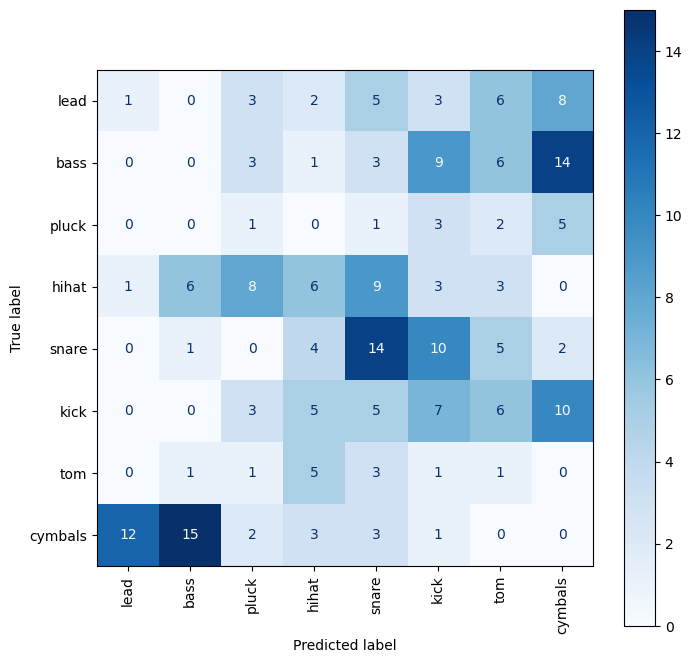

In [7]:
# 4. Visualizing
def confusion_matrix(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        true_idx = y_true[i]
        pred_idx = y_pred[i]
        conf_mat[true_idx][pred_idx] += 1
    return conf_mat

def plot_confusion_matrix(conf_mat, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=90)  # x축 레이블을 90도 기울임
    plt.show()

num_classes = len(class_index_dict)
conf_mat = confusion_matrix(ground_truth, torch.argmax(ranking, dim=1), num_classes)
class_names = list(class_index_dict.keys())
plot_confusion_matrix(conf_mat, class_names)

# Genre Classification

In [8]:
# 1. labels/audio/text files path  

# files
class_index_dict_path = 'labels/genre.json'
column_name = 'genre' # 'genre', 'artist'


In [9]:
# 2. Pretrained Model calling
model = laion_clap.CLAP_Module(enable_fusion=True)
model.load_ckpt()

with zipfile.ZipFile(zip_files_path) as zip:
    zip.extractall(unzip_files_folder_path)
class_index_dict = {k:v for k, v in json.load(open(class_index_dict_path)).items()}
audio_files = sorted(glob.glob(upzip_audio_files_path, recursive=True))
json_files = sorted(glob.glob(upzip_text_files_path, recursive=True)) 
ground_truth_idx = [class_index_dict[json.load(open(jf))[column_name][0]] for jf in json_files]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

In [10]:
print('='*50)
print(class_index_dict)
print('audio files 갯수:',len(audio_files))
print('json_files 갯수:',len(json_files))
print('ground_truth_idx 갯수:',len(ground_truth_idx))
print('ground_truth_idx :' ,ground_truth_idx)

{'hiphop': 0, 'disco': 1, 'pop': 2}
audio files 갯수: 232
json_files 갯수: 232
ground_truth_idx 갯수: 232
ground_truth_idx : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [11]:
# 3. Zero-shot processing
with torch.no_grad():
    ground_truth = torch.tensor(ground_truth_idx).view(-1, 1)
    # Get text features
    all_texts = ["This song is " + t for t in class_index_dict.keys()]
    text_embed = model.get_text_embedding(all_texts)
    audio_embed = model.get_audio_embedding_from_filelist(x=audio_files) 
    print('text_embed shape :',text_embed.shape)
    print('audio_embed shape :',audio_embed.shape)
    ranking = torch.argsort(torch.tensor(audio_embed) 
                            @ torch.tensor(text_embed).t(), 
                            descending=True)
    preds = torch.where(ranking == ground_truth)[1]
    preds_text=preds
    preds = preds.cpu().numpy()
    metrics = {}
    metrics[f"mean_rank"] = preds.mean() + 1
    metrics[f"median_rank"] = np.floor(np.median(preds)) + 1
    for k in [1, 2, 3, 5]:
        metrics[f"R@{k}"] = np.mean(preds < k)
    # map@10
    metrics[f"mAP@10"] = np.mean(np.where(preds < 10, 1 / (preds + 1), 0.0))
    print("="*50)
    print("Zeroshot Classification Results:")
    for k, v in metrics.items():
        print(f"{k}: {round(v, 4):.4f}")

text_embed shape : (3, 512)
audio_embed shape : (232, 512)
Zeroshot Classification Results:
mean_rank: 1.8233
median_rank: 2.0000
R@1: 0.4267
R@2: 0.7500
R@3: 1.0000
R@5: 1.0000
mAP@10: 0.6717


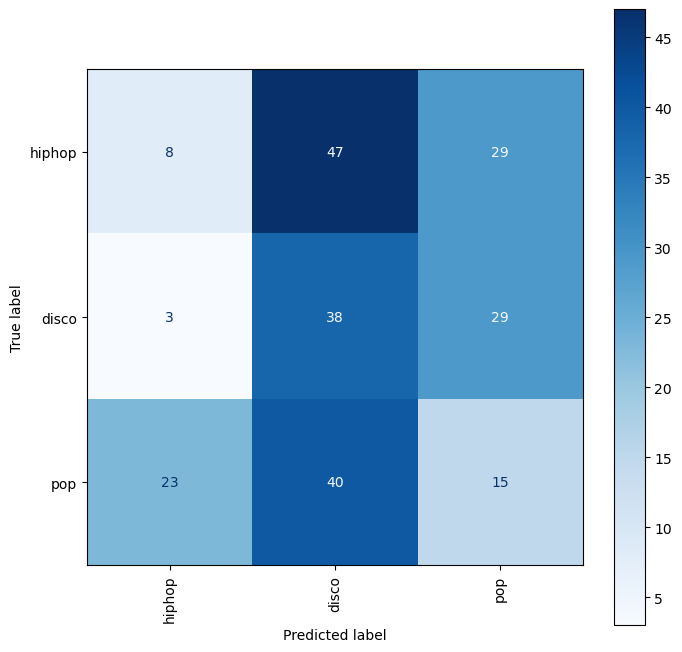

In [12]:
# 4. Visualizing
def confusion_matrix(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        true_idx = y_true[i]
        pred_idx = y_pred[i]
        conf_mat[true_idx][pred_idx] += 1
    return conf_mat

def plot_confusion_matrix(conf_mat, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=90)  # x축 레이블을 90도 기울임
    plt.show()

num_classes = len(class_index_dict)
conf_mat = confusion_matrix(ground_truth, torch.argmax(ranking, dim=1), num_classes)
class_names = list(class_index_dict.keys())
plot_confusion_matrix(conf_mat, class_names)

# Extract Embedding Value and Calculating Cosine Similarlity

In [13]:
# quantization
def int16_to_float32(x):
    return (x / 32767.0).astype(np.float32)


def float32_to_int16(x):
    x = np.clip(x, a_min=-1., a_max=1.)
    return (x * 32767.).astype(np.int16)

In [14]:
print(audio_embed.shape)
print(text_embed.shape)

(232, 512)
(3, 512)


In [16]:
dir_path = "./data/S300"
audio_files_path = os.path.join(dir_path, "**/*.wav")
audio_files = glob.glob(audio_files_path)
print(audio_files[:5])
print(len(audio_files))

# Directly get audio embeddings from audio files
audio_embed = model.get_audio_embedding_from_filelist(x = audio_files[:100], use_tensor=False)
print(audio_embed[:,-20:])
print(audio_embed.shape)

['./data/S300/soundsprayaiffel300/S268.wav', './data/S300/soundsprayaiffel300/S2007.wav', './data/S300/soundsprayaiffel300/S2029.wav', './data/S300/soundsprayaiffel300/S510.wav', './data/S300/soundsprayaiffel300/S1687.wav']
232
[[-0.03753933  0.06385248  0.002909   ... -0.00621989 -0.04789702
   0.00855306]
 [-0.04895413  0.02146771  0.0245784  ...  0.08197562  0.02774697
  -0.01991199]
 [-0.00511437  0.10446858  0.01391678 ... -0.04842365 -0.09128889
  -0.05311398]
 ...
 [-0.03704373 -0.02177103  0.00067297 ...  0.05260468 -0.04870749
   0.0404985 ]
 [ 0.00568145 -0.03243022  0.0949775  ...  0.02521823 -0.00573575
  -0.00681162]
 [ 0.04752331 -0.00527128 -0.02157602 ... -0.05051094 -0.03547497
   0.03409264]]
(100, 512)


In [17]:
text_files_path = os.path.join(dir_path, "**/*.json")
text_files = glob.glob(text_files_path)
print(text_files[:5])
print(len(text_files))

['./data/S300/soundsprayaiffel300/S1197.json', './data/S300/soundsprayaiffel300/S1013.json', './data/S300/soundsprayaiffel300/S1642.json', './data/S300/soundsprayaiffel300/S559.json', './data/S300/soundsprayaiffel300/S499.json']
232


In [18]:
# Directly get audio embeddings from audio files
text_embed = model.get_text_embedding(text_files[:100])
print(text_embed[:,-20:])
print(text_embed.shape)

[[-0.05428312  0.03001472 -0.09210999 ...  0.00064611 -0.05973215
   0.0057439 ]
 [-0.04769276  0.02474638 -0.08609554 ...  0.00733666 -0.06997332
   0.01742218]
 [-0.06044169  0.02121128 -0.08507604 ... -0.00531788 -0.06531565
   0.00848995]
 ...
 [-0.0406495   0.02240966 -0.08307461 ...  0.00523313 -0.07272562
   0.01288681]
 [-0.07825659  0.05818085 -0.06917134 ...  0.00227404 -0.06792954
   0.01750165]
 [-0.07005853  0.03552961 -0.08458321 ... -0.01647849 -0.06502552
   0.02809951]]
(100, 512)


In [19]:
# S300_Model_Cosine_Similarlity [:100]
# Compute cosine similarity
norm_text = np.linalg.norm(text_embed, axis=1, keepdims=True)
norm_audio = np.linalg.norm(audio_embed, axis=1, keepdims=True)
dot_product = np.dot(text_embed, audio_embed.T)
cos_similarity = dot_product / (norm_text * norm_audio.T)

# Compute row-wise mean
row_means = np.mean(cos_similarity, axis=1)
# Compute overall mean
overall_mean = np.mean(row_means)

print("Overall mean cosine similarity:", overall_mean)

Overall mean cosine similarity: -0.052498635
